<a href="https://colab.research.google.com/github/anshupandey/Working_with_Large_Language_models/blob/main/WWL_C19_VertexAI_image_editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Editing with Imagen 2 on Vertex AI

## Overview

[Imagen 2 on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/image/overview) brings Google's state of the art generative AI capabilities to application developers. With Imagen 2 on Vertex AI, application developers can build next-generation AI products for image editing.

This notebook focuses on **image editing** only. Learn more about [editing with Imagen](https://cloud.google.com/vertex-ai/generative-ai/docs/image/edit-images).


### Objectives

In this notebook, you will be exploring the image editing features of Imagen using the Vertex AI Python SDK. You will

- Edit an image with a text prompt and a mask.
- Insert an object into an image.
- Remove an object from an image.
- Pad and outpaint an image.
- Generate new backgrounds for product images.


### Costs

- This notebook uses billable components of Google Cloud:
  - Vertex AI (Imagen)

- Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install dependencies

In [5]:
! pip install --quiet --upgrade --user google-cloud-aiplatform
! pip install --quiet gradio==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s 

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and enable the Vertex AI API.

Learn more about setting up a project and a development environment.

In [2]:
PROJECT_ID = "jrproject-402905"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [3]:
# @title Import libraries
# @markdown Run this cell before proceeding to import libraries and define utility functions. \
# @markdown You will also load the imagegeneration@006 model from the Vertex AI SDK.

import io
import math
from typing import Any, List

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from vertexai.preview.vision_models import Image as Vertex_Image
from vertexai.preview.vision_models import ImageGenerationModel, ImageGenerationResponse


# Gets the image bytes from a PIL Image object.
def get_bytes_from_pil(image: Image) -> bytes:
    byte_io_png = io.BytesIO()
    image.save(byte_io_png, "PNG")
    return byte_io_png.getvalue()


# Corrects the orientation of an image if needed. Uses the EXIF tag 274
# to check if an image has been rotated and if so, reverts it.
def maybe_rotate(img_pil: Image):
    exif = img_pil.getexif()
    rotation = exif.get(274)

    if rotation == 3:
        img_pil = img_pil.rotate(180, expand=True)
    elif rotation == 6:
        img_pil = img_pil.rotate(270, expand=True)
    elif rotation == 8:
        img_pil = img_pil.rotate(90, expand=True)
    return img_pil


# Extract bounding boxes from a mask.
def get_b_box_from_mask(
    mask_image: np.ndarray, box_area_threshold: int = 50
) -> np.ndarray:
    contours, _ = cv.findContours(mask_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    b_boxes = np.zeros((len(contours), 4))
    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)
        b_boxes[i] = (x, y, x + w, y + h)
    b_boxes = filter(
        lambda x: (x[2] - x[0]) * (x[3] - x[1]) > box_area_threshold, b_boxes
    )
    b_boxes = sorted(b_boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
    return b_boxes


# Edits specific areas and pastes them back into the original image.
def crop_insert_paste(
    generation_model: ImageGenerationModel,
    image: Image,
    mask: Image,
    boxes: np.array,
    pad_ratio: int,
    prompt: str,
    neg_prompt: str,
    seed: int = 0,
    mask_dilation: float = 0.01,
    guidance_scale: int = 60,
    samples: int = 4,
):
    generated_imgs = [image.copy() for _ in range(samples)]
    for box in boxes:
        # Calculate cropping area with padding.
        box_w_pad = pad_ratio * (box[2] - box[0])
        box_h_pad = pad_ratio * (box[3] - box[1])
        x1 = np.round(np.clip(box[0] - box_w_pad, 0, image.width)).astype("int")
        x2 = np.round(np.clip(box[2] + box_w_pad, 0, image.width)).astype("int")
        y1 = np.round(np.clip(box[1] - box_h_pad, 0, image.height)).astype("int")
        y2 = np.round(np.clip(box[3] + box_h_pad, 0, image.height)).astype("int")

        im_crop = image.crop([x1, y1, x2, y2])
        mask_crop = mask.crop([x1, y1, x2, y2])
        image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(im_crop))
        mask_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(mask_crop))

        # Edit the cropped area of the image.
        generated_crops = generation_model.edit_image(
            prompt=prompt,
            negative_prompt=neg_prompt,
            base_image=image_vertex,
            mask=mask_vertex,
            number_of_images=samples,
            edit_mode="inpainting-insert",
            seed=seed,
            guidance_scale=guidance_scale,
            mask_dilation=mask_dilation,
        )

        # Paste the generated edits of the cropped area into the corresponding
        # positions in the base image.
        for i, crop in enumerate(generated_crops.images):
            generated_imgs[i].paste(crop._pil_image, (x1, y1))
    return generated_imgs


# Pads an image for outpainting. Provides options to control the positioning of
# the original image.
def pad_to_target_size(
    source_image,
    target_size=(1536, 1536),
    mode="RGB",
    vertical_offset_ratio=0,
    horizontal_offset_ratio=0,
    fill_val=255,
):
    orig_image_size_w, orig_image_size_h = source_image.size
    target_size_w, target_size_h = target_size

    insert_pt_x = (target_size_w - orig_image_size_w) // 2 + int(
        horizontal_offset_ratio * target_size_w
    )
    insert_pt_y = (target_size_h - orig_image_size_h) // 2 + int(
        vertical_offset_ratio * target_size_h
    )
    insert_pt_x = min(insert_pt_x, target_size_w - orig_image_size_w)
    insert_pt_y = min(insert_pt_y, target_size_h - orig_image_size_h)

    if mode == "RGB":
        source_image_padded = Image.new(
            mode, target_size, color=(fill_val, fill_val, fill_val)
        )
    elif mode == "L":
        source_image_padded = Image.new(mode, target_size, color=(fill_val))
    else:
        raise ValueError("source image mode must be RGB or L.")

    source_image_padded.paste(source_image, (insert_pt_x, insert_pt_y))
    return source_image_padded


# Pads and resizes image and mask to the same target size.
def pad_image_and_mask(
    image_vertex: Vertex_Image,
    mask_vertex: Vertex_Image,
    target_size,
    vertical_offset_ratio,
    horizontal_offset_ratio,
    viz=True,
):
    image_vertex.thumbnail(target_size)
    mask_vertex.thumbnail(target_size)

    image_vertex = pad_to_target_size(
        image_vertex,
        target_size=target_size,
        mode="RGB",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=0,
    )
    mask_vertex = pad_to_target_size(
        mask_vertex,
        target_size=target_size,
        mode="L",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=255,
    )
    if viz:
        print(
            f"image size(with x height): {image_vertex.size[0]} x {image_vertex.size[1]}"
        )
        plt.axis("off")
        plt.imshow(image_vertex)
        plt.imshow(mask_vertex, alpha=0.3)
        plt.title("Padded image and mask overlay")
    return image_vertex, mask_vertex


# Displays images in a grid below the cell
def display_images_in_grid(images: List[Any]) -> None:
    """Displays the provided images in a grid format. 4 images per row.

    Args:
        images: A list of images to display.
    """

    # Determine the number of rows and columns for the grid layout.
    nrows: int = math.ceil(len(images) / 4)  # Display at most 4 images per row
    ncols: int = min(len(images) + 1, 4)  # Adjust columns based on the number of images

    # Create a figure and axes for the grid layout.
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display the image in the current axis.
            if hasattr(images[i], "_pil_image"):
                image = images[i]._pil_image
            else:
                image = images[i]
            ax.imshow(image)

            # Adjust the axis aspect ratio to maintain image proportions.
            ax.set_aspect("equal")

            # Disable axis ticks for a cleaner appearance.
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Hide empty subplots to avoid displaying blank axes.
            ax.axis("off")

    # Adjust the layout to minimize whitespace between subplots.
    plt.tight_layout()

    # Display the figure with the arranged images.
    plt.show()


IMAGE_TMP_FILE_PATH = "base_image.png"
MASK_TMP_FILE_PATH = "mask.png"

IMAGE_GENERATION_MODEL = "imagegeneration@006"
generation_model = ImageGenerationModel.from_pretrained(IMAGE_GENERATION_MODEL)

## Set an image and mask

In [6]:
# @title Upload image and draw mask
# @markdown Run this cell to enable a Gradio UI. \
# @markdown You can then upload or paste the image you want to edit. \
# @markdown Use the `brush` button in the editor to draw a mask over the area of the image
# @markdown you want to edit.

import time

import gradio as gr


def sleep(im):
    time.sleep(5)
    return [im["background"], im["layers"][0], im["layers"][1], im["composite"]]


def predict(im):
    base_image = im["background"]
    threshold = 128
    raw_mask = im["layers"][0]
    width, height = base_image.size
    raw_mask.resize((width, height))
    bw_mask = raw_mask.convert("L").point(
        lambda x: 255 if x > threshold else 0, mode="1"
    )
    base_image.save("base_image.png")
    bw_mask.save("mask.png")
    return bw_mask


def set_mask(mask):
    if mask is not None:
        mask.save("mask.png")


with gr.Blocks(
    theme=gr.themes.Soft(),
    css="""
.image_preview {
    height: auto;
    padding: 50px 0;
}
""",
) as demo:
    with gr.Row():
        im = gr.ImageEditor(
            label="Base image",
            type="pil",
            transforms=[],
            layers=False,
            sources=("upload", "clipboard"),
            brush=gr.Brush(colors=["#3aa8fc"], color_mode="L"),
            format="png",
        )
        im_preview = gr.Image(
            label="Image mask",
            format="png",
            elem_classes="image_preview",
            sources=("upload", "clipboard"),
            height=500,
            container=True,
            interactive=True,
        )
    im.change(predict, outputs=im_preview, inputs=im)
    im_preview.change(set_mask, inputs=im_preview)

if __name__ == "__main__":
    demo.launch(height=600, quiet=True)

Running on public URL: https://11a843282138261f31.gradio.live


### [Optional] Generate with Imagen
Use the `generate_images` function with Imagen to create an image. All you need is a text prompt.

In [ ]:
PROMPT = "a deer on a grassy barn field looking at the camera"

response: ImageGenerationResponse = generation_model.generate_images(
    prompt=PROMPT,
)

response.images[0].save(IMAGE_TMP_FILE_PATH)
image_pil = Image.open(IMAGE_TMP_FILE_PATH)

# Resize to a maximum dimension of 1024
image_pil.thumbnail((1024, 1024))
plt.axis("off")
display(image_pil)
print(f"Image size(with x height): {image_pil.size[0]} x {image_pil.size[1]}")

## Edit images
Use the `edit_image` function to edit a base image. You can set the following parameters:

- `prompt` - A text prompt describing the object to insert.
- `negative_prompt` - [Optional] - Define what you DON'T want to see.
- `samples` - The number of edited images to generate. An integer between 1 to 4.
- `mask_dilation` - The dilation percentage of the mask. Dilation sets the mask sensitivity around edges. This is helpful for thin objects (e.g. spokes on a bicycle wheel). A decimal value between 0 and 1 and default at 0.01 for `inpainting-insert`. 0 means no dilation and 1 means the entire image will be covered by the mask.

- `guidance_scale` - Controls how much the model adheres to the text prompt. Large values increase output and prompt alignment, but may compromise image quality. A value between 0 to 500, default at 60.
- `seed` - Pseudo random seed for reproducible generated outcome.

### Insert objects into an image

With the `inpainting-insert` edit mode, you add a new object to an image.

Best practices:
 - If providing a mask, use medium to large masks.
 - The edits should be reasonable in regards to lighting, placement, and creating a realistic scene.
 - Use related context (e.g., natural object interactions, object size reference, composition) in the text prompt.

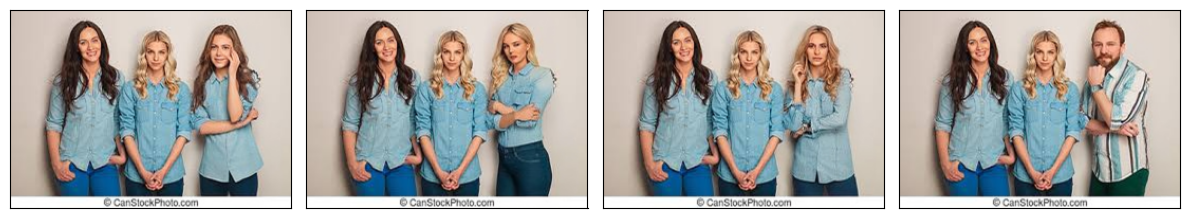

In [22]:
PROMPT = "man"
NEGATIVE_PROMPT = "western design"
SAMPLES = 4
MASK_DILATION = 0.01
GUIDANCE_SCALE = 500
SEED = 0

image_pil = Image.open(IMAGE_TMP_FILE_PATH)
mask_pil = Image.open(MASK_TMP_FILE_PATH)

image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(image_pil))
mask_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(mask_pil))

generated_images = generation_model.edit_image(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    base_image=image_vertex,
    mask=mask_vertex,
    number_of_images=SAMPLES,
    edit_mode="inpainting-insert",
    seed=SEED,
    guidance_scale=GUIDANCE_SCALE,
    mask_dilation=MASK_DILATION,
)

display_images_in_grid(generated_images.images)

In [18]:
generated_images.images[1].save("myimg.jpg")

#### Tip: inpainting-insert for small objects

For some small objects, you can get better results with this method.

1. crop RGB image and mask, set a prompt that describes the area to be edited.
2. use the cropped image and mask to edit the image.
3. paste the generated edited images back into the original image.

In [23]:
image_pil = Image.open(IMAGE_TMP_FILE_PATH)
mask_pil = Image.open(MASK_TMP_FILE_PATH)

b_boxes = get_b_box_from_mask(np.array(mask_pil))
generated_images = crop_insert_paste(
    generation_model,
    image_pil,
    mask_pil,
    b_boxes,
    pad_ratio=0.5,
    prompt=PROMPT,
    neg_prompt=NEGATIVE_PROMPT,
    samples=SAMPLES,
    mask_dilation=MASK_DILATION,
    seed=SEED,
    guidance_scale=GUIDANCE_SCALE,
)

display_images_in_grid(generated_images)

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'findContours'
> Overload resolution failed:
>  - image data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'image'


### Remove objects from an image

Set the `edit_mode` to `inpainting-remove` to remove objects from an image.

Best practices:
 - Uses small / medium size masks. Using large size masks is similar to generating new objects
 - When the target objects throw a shadow, including the shadow in the mask significantly improves result quality. Omitting shadows from input masks provides a cue for the model to generate a corresponding object to the shadow.

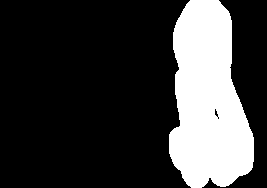

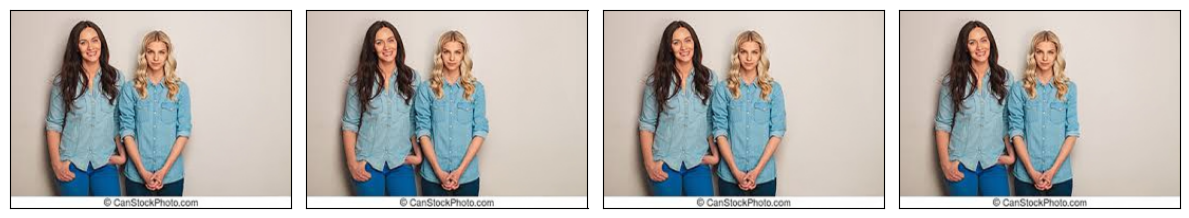

In [24]:
# A text prompt and negative prompt for `inpainting-remove` are not required.
# You can set the prompt argument to an empty string.
PROMPT = ""
SAMPLES = 4
MASK_DILATION = 0.03
GUIDANCE_SCALE = 60
SEED = 0

image_pil = Image.open(IMAGE_TMP_FILE_PATH)
mask_pil = Image.open(MASK_TMP_FILE_PATH)
display(mask_pil)
image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(image_pil))
mask_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(mask_pil))

generated_images = generation_model.edit_image(
    prompt=PROMPT,
    base_image=image_vertex,
    mask=mask_vertex,
    number_of_images=SAMPLES,
    edit_mode="inpainting-remove",
    seed=SEED,
    guidance_scale=GUIDANCE_SCALE,
    mask_dilation=MASK_DILATION,
)

display_images_in_grid(generated_images.images)

### Expand an image outwards

Use the `outpainting` edit mode to expand an image content beyond its boundaries.

Best practices:
- For optimal results, start with smaller expansions.
- This feature works best with images that have softer, more blended textures.

#### Prepare outpainting image data

To use the outpainting feature, you must prepare the base image by padding some empty space around it. This empty space will be filled in by Imagen. You can run the cell below to create some padding around your image.

image size(with x height): 1875 x 2500


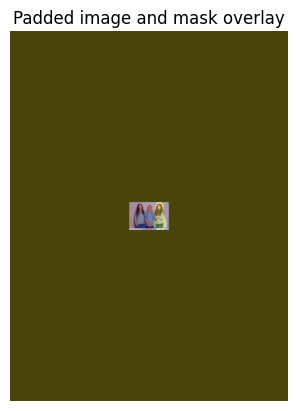

In [25]:
# Set rotation degree. Positive degrees to rotate the image anti-clockwise, negative degrees for clockwise.
rotation_deg = 0
# Pad input image and mask to new size with *target_size_h* as height.
target_size_h = 2500
# Set the width-to-height aspect ratio for the outpainted images.
width_to_height_aspect_ratio = "3/4"
# Move input image *target_size* x *vertical_offset_ratio* pixels vertically, positive value means downward \
vertical_offset_ratio = 0
# Move input image *target_size* x *horizontal_offset_ratio* pixels horizontally, positive value moves image to the right.
horizontal_offset_ratio = 0
# Visualize padded image and mask.
viz = True

image_pil = Image.open(IMAGE_TMP_FILE_PATH)
mask_pil = Image.open(MASK_TMP_FILE_PATH)

if "mask_pil" not in globals():
    # Start with a default black (no-change) mask, useful for outpainting.
    mask_pil = Image.new("L", image_pil.size, 0)

# Prepare the outpainting input image and mask
rot_img = image_pil.rotate(rotation_deg, expand=1, resample=Image.Resampling.BICUBIC)
rot_mask = mask_pil.rotate(rotation_deg, expand=1, fillcolor=255)
target_size_w = int(target_size_h * eval(width_to_height_aspect_ratio))
target_size = (target_size_w, target_size_h)

image_pil_outpaint, mask_pil_outpaint = pad_image_and_mask(
    rot_img,
    rot_mask,
    target_size,
    vertical_offset_ratio,
    horizontal_offset_ratio,
    viz=viz,
)

#### Outpaint images

Once you have padded the image, you can use the `outpainting` edit mode to fill the empty space as shown below.

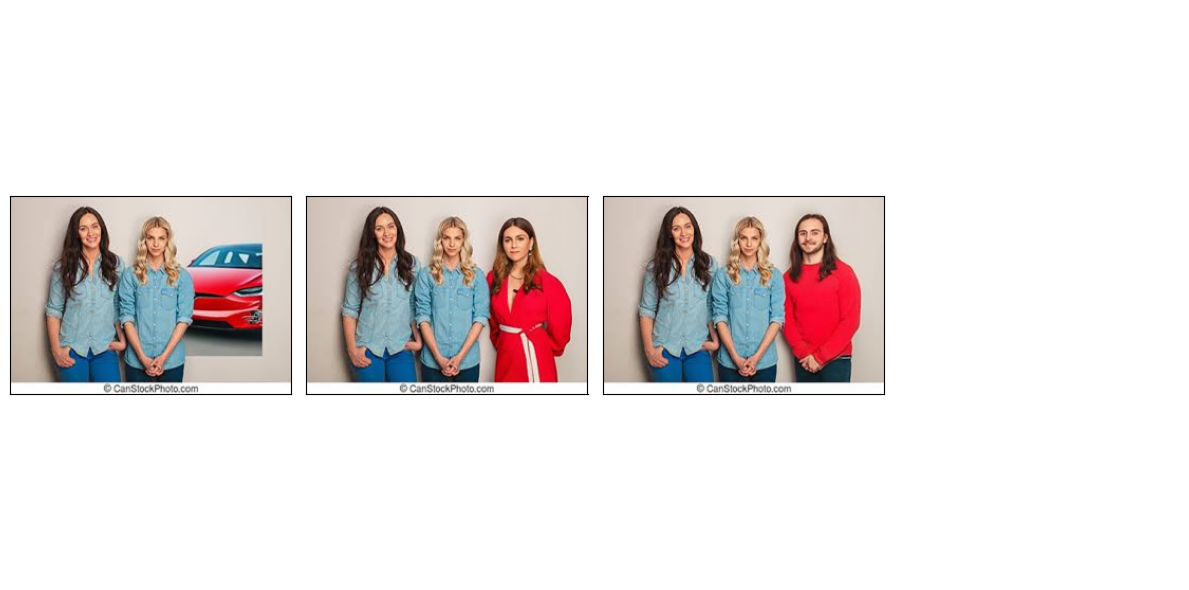

In [29]:
# [Optional]Set a positive prompt to define what you want to see in outpainted region,
# If left empty, the model takes the context cue from the base image.
PROMPT = "A red tesla car"
# [Optional] Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = ""
SAMPLES = 4
# Default at 0.03 for `outpainting`.
MASK_DILATION = 0.03
GUIDANCE_SCALE = 450
SEED = 0

image_pil = Image.open(IMAGE_TMP_FILE_PATH)
mask_pil = Image.open(MASK_TMP_FILE_PATH)
image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(image_pil))
mask_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(mask_pil))

generated_images = generation_model.edit_image(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    base_image=image_vertex,
    mask=mask_vertex,
    number_of_images=SAMPLES,
    edit_mode="outpainting",
    seed=SEED,
    guidance_scale=GUIDANCE_SCALE,
    mask_dilation=MASK_DILATION,
)

display_images_in_grid(generated_images.images)

### Generate a new background for product images

Use Imagen's `product-image` edit mode to set a new background for product images. Imagen excels at generating high image quality background content that fits the lighting and shadows of the product - great for advertisements and online shopping. The `product-image` mode always returns four 1024x1024 images.

Best practices:

- Imagen generates the foreground product mask for you. Avoid using products or objects that have thin, isolated parts, e.g. long handbag straps, a single golf club.
- Put the desired objects closer to the bottom of a square input image. This is achieved by pre-padding objects in a square input image and setting product_position to `fixed` in the API.

You can use the `product_position` parameter to set how the primary product is placed in the generated images.

*   `reposition`- Re-centers the primary product in the generated image.
*   `fixed`- For square input images, this will keep the primary product in the same relative location.

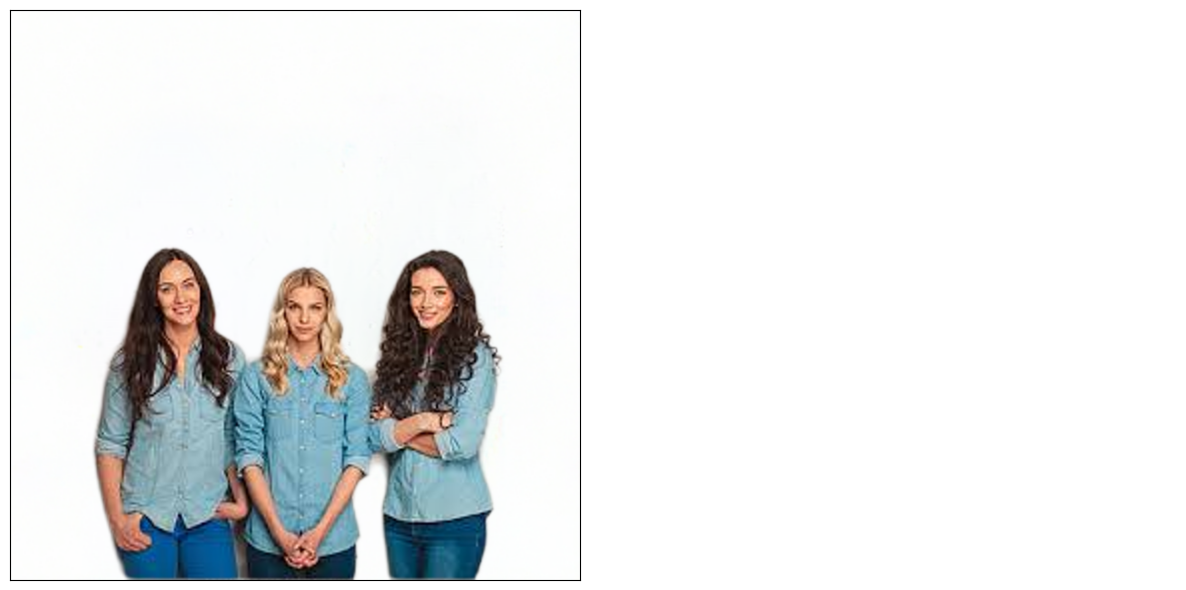

In [32]:
# Set a text prompt that describes the new image you want to see with the product.
PROMPT = "green grass field"
# Recenter the primary product in the generated image
PRODUCT_POSITION = "reposition"

image_pil = Image.open(IMAGE_TMP_FILE_PATH)
image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(image_pil))

generated_images = generation_model.edit_image(
    prompt=PROMPT,
    base_image=image_vertex,
    edit_mode="product-image",
    product_position=PRODUCT_POSITION,
)

display_images_in_grid(generated_images.images)

## Conclusion

You have explored the Imagen's image editing features through the Vertex AI Python SDK, including the additional parameters that influence image generation.


Check out the Vertex AI reference to learn more about how to [Edit image prompts](https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide#edit-prompts).